<h1><center>Named Entity Recognition Model using  Clinical BERT </center></h1>
<h4><center>Final Project W266</center></h4>


<h3><center>SUMMARY</center></h3>

In this notebook, we will look at implementing various BERT models to understand the significance of domain specific contexts with respect to fine tuning NER task.

- The various BERT models used in the notebook are listed below.

__BERT:__ 
>"BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", by Devlin/Chang/Lee/Toutanova, Google AI Language)

__BioBERT:__ 
>A pre-trained biomedical language representation model for biomedical text mining by Jinhyuk Lee, Wonjin Yoon, Sungdong Kim, Donghyeon Kim, Sunkyu Kim, Chan Ho So, Jaewoo Kang

__SciBERT:__
>A Pretrained Language Model for Scientific Text by Iz Beltagy, Kyle Lo, Arman Cohan

__ClinicalBert:__
>Modeling Clinical Notes and Predicting Hospital Readmission by Kexin Huang, Jaan Altosaar, Rajesh Ranganath

>Publicly Available Clinical BERT Embeddings by Emily Alsentzer, John R. Murphy, Willie Boag, Wei-Hung Weng, Di Jin, Tristan Naumann, Matthew B. A. McDermott


Models used and their corresponding Corpora used:


__Base Bert Cased -__  

>Wikipedia + BookCorpus

__BioBert Cased with PubMed and PMC - __

>English Wikipedia, General BooksCorpus, General PubMed Abstracts, PMC Full-text articles

__SciBert Cased -__

>1.14M papers from Semantic Scholar (Ammar et al., 2018)

__biobert_pretrain_output_all_notes_150000__

>MIMIC text from all note types on BioBert


__biobert_pretrain_output_disch_100000__

>MIMIC text from all discharge summaries on BioBert


We look at the effect of also fine-tuning BERT layers which are pre-trained with clinical context. 


### 1. Data



In [49]:
!tail -20 'ner_dataset.csv'

",",",",O
M.D,NNP,O
JA25,NNP,O
Attending:,NNP,O
SYDNEY,NNP,O
DUESTERHAUS,NNP,O
",",",",O
M.D,NNP,O
MG85,NNP,O
EQ681/3978,NNP,O
Batch:,NNP,O
37609,CD,O
Index,NNP,O
No,NNP,O
FHOW8875S8,NNP,O
D:,NNP,O
6/10,CD,O
T:,NNP,O
1/22,CD,O
[report_end],NN,O


We see the words line-by-line, the labels (POS and NER), and the sentence boundaries. Perfect.

In [50]:
!pip install seqeval[gpu]

In [51]:
import warnings 
warnings.filterwarnings('ignore')
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
#import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange


from datetime import datetime
import os
import sys
import zipfile



In [52]:

# Define mddaximal length of input 'sentences' (post tokenization).
max_word = 40
max_length = 64

In [53]:

import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

In [54]:
MAX_LEN = 128
bs = 32

In [55]:
print(os.listdir("/root"))
print(os.listdir("/root/biobert_v1.0_pubmed_pmc"))


['All Models.ipynb', 'scibert_scivocab_cased', 'cuda-repo-ubuntu1604-10-1-local-10.1.168-418.67_1.0-1_amd64.deb', 'ner_tags', 'vocab.txt', 'biobert_pretrain_output_disch_100000', 'biobert_working-pytorch-gpu_v1.ipynb', '.gnupg', 'clibert.bin', 'sentence_boundaries.ipynb', 'scibert_working-pytorch-gpu_v1.ipynb', 'all_bert_models-50.ipynb', 'validation_sentences.csv', 'Baseline_model.ipynb', 'biobert.bin', 'biobert_pretrain_output_all_notes_150000', 'clinicalbert.bin', 'clinicalbert_pytorch-gpu_v1_notes.ipynb', 'attention_decoder.py', 'bert_config.json', 'cuda-repo-ubuntu1604-10-1-local-10.1.105-418.39_1.0-1_amd64.deb', 'validation_ner.csv', 'pytorch_model.bin', 'sentence_model.h5', '.profile', '.config', 'ner_dataset.csv', 'clinicalbert_working-pytorch-gpu_v1.ipynb', 'data', 'convert_to_pytorch_wt.ipynb', '.keras', '.nv', '.bash_history', 'eos.pyc', 'connengine.ipynb', 'answers', 'parser-bert.ipynb', 'bert_working-pytorch-gpu_v1.ipynb', '.pytorch_pretrained_bert', 'best_model.hdf5', 'co

In [56]:
VOCAB = '/root/biobert_v1.0_pubmed_pmc/vocab.txt'
MODEL = '/root/biobert_v1.0_pubmed_pmc'

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [58]:
torch.cuda.get_device_name(0) 

'Tesla P100-PCIE-16GB'

## III. Data Preprocessing <a id="preprocess" />

### III.1 BERT Tokenizer<a id="tokenizer" />

We first start by defining and exploring the BERT tokenizer:

In [59]:
tokenizer = BertTokenizer.from_pretrained('/root/biobert_v1.0_pubmed_pmc', do_lower_case=False)

In [60]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer1 = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Let's play with the tokenizer. You will see that the tokenizer occasionally splits one word into multiple tokens. Why is that the case? Because the approach of using word pieces reduces the vocabulary size and/or number of unknown words.

Here is one example:

In [61]:
# Tokenized input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)
tokenized_text1 = tokenizer1.tokenize(text)
print (tokenized_text)
print (tokenized_text1)


['[CLS]', 'Who', 'was', 'Jim', 'He', '##nson', '?', '[SEP]', 'Jim', 'He', '##nson', 'was', 'a', 'puppet', '##eer', '[SEP]']
['[CLS]', 'Who', 'was', 'Jim', 'He', '##nson', '?', '[SEP]', 'Jim', 'He', '##nson', 'was', 'a', 'puppet', '##eer', '[SEP]']


In [62]:
tokenizer.tokenize('I\'ll learn to swim in 12342 years.')

['I', "'", 'll', 'learn', 'to', 'swim', 'in', '123', '##42', 'years', '.']

Note how the "I'll" phrase and the number '12342' got split. This already highlights an area one needs to address: splitting of tokens will need to be accounted for in the labeling.

In [63]:
tokenizer.convert_tokens_to_ids([
    '[CLS]', 'i', "'",'ll', 'learn','to','swim','in','123', '##42', 'years', '.'])

[101, 178, 112, 1325, 3858, 1106, 11231, 1107, 13414, 23117, 1201, 119]

In [64]:
tokenizer.convert_ids_to_tokens([20958])

['Faye']

Good. Now we are ready to use it for our text.

### III.2. Extraction<a id="extract"/>


We have seen above how the data set looks. We can now turn to the pre-processing and creating the input for BERT. Specifically, we need to:

1) Tokenize the sentences. Note again that one word can be split into multiple tokens, and we need to insert custom labels when that happens to make sure we don't mess up the alignment. We choose a new 'nerX' label here.

2) Create BERT tokens and add [CLS], [PAD], etc.

3) Convert these tokens into ids, also via the tokenizer. These qill create the sentence_ids.

4) Create the mask ids. Mask out all of the padding tokens.

5) Create the sequence ids. In our case, they are all '0' as we do not compare or even have multiple sentences in one example.

To do this, we first define a helper function:

In [65]:
def addWord(word, pos, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    
    return addDict


Let's see what it does:

In [66]:
addWord('protest', 'VB', 'O')

{'wordToken': ['protest'],
 'posToken': ['VB'],
 'nerToken': ['O'],
 'tokenLength': 1}

In [67]:
addWord('Iraq', 'NNP', 'B-geo')

{'wordToken': ['Iraq'],
 'posToken': ['NNP'],
 'nerToken': ['B-geo'],
 'tokenLength': 1}

In [68]:
addWord('10000', 'CD', 'O')

{'wordToken': ['1000', '##0'],
 'posToken': ['CD', 'posX'],
 'nerToken': ['O', 'nerX'],
 'tokenLength': 2}

We are now ready to convert the text file into appropriate arrays:

In [69]:
"""
Read the file line by line and construct sentences. A sentence end is marked by the word 'sentence' in the next row.
You need to take care of that. Also, you need to cap sentence length using max_length. Sentences which are shorter than 
max_length need to be padded. Also, we choose to end all sentences with a [SEP] token, padded or not. 
"""

with io.open('ner_dataset.csv', 'r', encoding='utf-8', errors='ignore') as train:
    text = train.readlines()


# lists for sentences, tokens, labels, etc.  
sentenceList = []
word_count = 0
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']

for line in text:
    
    cleanLine = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '', line)  # deal with '"10,000"' and convert them to '10000' 

    word, pos, ner = cleanLine.split(',')
    
    ner = ner[:-1]   # remove DOS token
    
    # if new sentence starts
    if (word_count >= max_word -1):            
            
        sentenceLength = min(max_length -1, len(sentenceTokens))
        sentLengthList.append(sentenceLength)
        
                    
        # Create space for at least a final '[SEP]' token
        if sentenceLength >= max_length - 1: 
            sentenceTokens = sentenceTokens[:max_length - 2]
            posTokens = posTokens[:max_length - 2]
            nerTokens = nerTokens[:max_length - 2]

        # add a ['SEP'] token and padding
        
        sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
        
        posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
        nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )
            
        sentenceList.append(sentence)

        sentenceTokenList.append(sentenceTokens)

        bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
        bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
        bertSequenceIDs.append([0] * (max_length))
                             
        posTokenList.append(posTokens)
        nerTokenList.append(nerTokens)
        
        sentence = ''
        sentenceTokens = ['[CLS]']
        posTokens = ['[posCLS]']
        nerTokens = ['[nerCLS]']
        
        sentence += ' ' + word
        word_count = 0
    
    word_count += 1
    addDict = addWord(word, pos, ner)

    sentenceTokens += addDict['wordToken']
    posTokens += addDict['posToken']
    nerTokens += addDict['nerToken']

# The first two list elements need to be removed. 1st line in file is a-typical, and 2nd line does not end a sentence   
sentLengthList = sentLengthList[2:]
sentenceTokenList = sentenceTokenList[2:]
bertSentenceIDs = bertSentenceIDs[2:]
bertMasks = bertMasks[2:]
bertSequenceIDs = bertSequenceIDs[2:]
posTokenList = posTokenList[2:]
nerTokenList = nerTokenList[2:]

What did this do?

In [70]:
print(sentLengthList[4])

47


In [71]:
print(bertSentenceIDs[4])

[101, 2103, 1115, 1123, 2555, 1125, 1151, 2221, 107, 107, 1105, 1175, 1127, 1185, 2091, 8661, 2879, 1895, 27631, 13066, 1224, 1608, 1109, 5884, 1104, 27631, 20702, 1166, 1103, 1736, 1104, 1103, 1480, 107, 107, 1170, 1134, 1553, 1131, 1108, 2752, 1171, 1106, 2001, 10805, 8643, 3875, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [72]:
print(sentenceTokenList[4])

['[CLS]', 'reported', 'that', 'her', 'foot', 'had', 'been', 'blue', '"', '"', 'and', 'there', 'were', 'no', 'Do', '##pp', '##ler', '##able', 'pulses', 'Color', 'later', 'returned', 'The', 'absence', 'of', 'pulses', 'persisted', 'over', 'the', 'course', 'of', 'the', 'night', '"', '"', 'after', 'which', 'point', 'she', 'was', 'referred', 'back', 'to', 'La', '##rg', '##rine', 'Medical', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [73]:
print(nerTokenList[4])

['[nerCLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'nerX', 'nerX', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'nerX', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]']


In [74]:
print(bertMasks[4])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


This looks right. Everything past the '[SEP]' token, i.e., the '[nerSEP]' label, is masked out. Also the sequence_ids are correct: there is only one sentence, so all ids should have the same value of zero.

In [75]:
print(bertSequenceIDs[4])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Looks reasonable. 


### III.3. Initial Data Analysis<a id="analysis" />

It is important to understand the dataset prior to doing any modeling or training. First, what are the length of the original sentences.

(array([   5.,    0.,    7.,    0.,    0.,   21.,    0.,    0.,   31.,
           0.,   44.,    0.,    0.,   51.,    0.,    0.,   69.,    0.,
          85.,    0.,    0.,  108.,    0.,    0.,  128.,    0.,  149.,
           0.,    0.,  163.,    0.,    0.,  169.,    0.,    0.,  178.,
           0.,  201.,    0.,    0.,  208.,    0.,    0.,  228.,    0.,
         228.,    0.,    0.,  224.,    0.,    0.,  222.,    0.,  192.,
           0.,    0.,  179.,    0.,    0.,  186.,    0., 4412.]),
 array([40.        , 40.37096774, 40.74193548, 41.11290323, 41.48387097,
        41.85483871, 42.22580645, 42.59677419, 42.96774194, 43.33870968,
        43.70967742, 44.08064516, 44.4516129 , 44.82258065, 45.19354839,
        45.56451613, 45.93548387, 46.30645161, 46.67741935, 47.0483871 ,
        47.41935484, 47.79032258, 48.16129032, 48.53225806, 48.90322581,
        49.27419355, 49.64516129, 50.01612903, 50.38709677, 50.75806452,
        51.12903226, 51.5       , 51.87096774, 52.24193548, 52.6129032

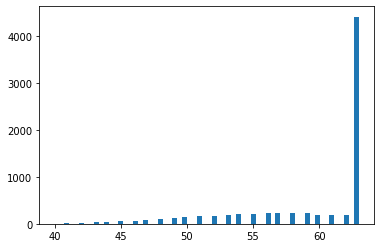

In [76]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

An average sentence length of ~25 (incl. extra tokens!) is roughly expected. It turns out that on these types of corpora an average sentence length of ~20 tends to be seen. The big spike on the right obviously corresponds to all sentences that we had to truncate. 

Next, we analyze the distribution of ner labels. First, we assign numbers to the labels and look at the overall distribution:

In [77]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4805a33f98>]],
      dtype=object)

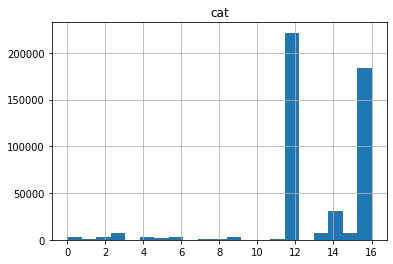

In [78]:
nerClasses[['cat']].hist(bins=21)

Looks like a lot of tables with value 16+... Let's see which labels these label numbers corresponds to:

In [79]:
nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

numNerClasses = nerDistribution.tag.nunique()

nerDistribution

,tag,cat,occurences
0,B-do,0,3520
1,B-du,1,485
2,B-f,2,3171
3,B-m,3,7443
4,B-mo,4,2664
5,B-r,5,1479
6,I-do,6,3146
7,I-du,7,1020
8,I-f,8,1109
9,I-m,9,3321


Interesting. 12 corresponds to 'O', and all 'extension' labels (i.e., those that were not part of the original data) occur at 13+. 

'O' is the most common token - by far.

### III.4. Baseline: Always picking 'Other'<a id="baseline" />

Let's see what a baseline would give for the actual text tokens, if I ALWAYS chose the most common token 'O':

In [80]:
O_occurences = nerDistribution.loc[nerDistribution.tag == 'O','occurences']
All_occurences = nerDistribution[nerDistribution.cat < 13]['occurences'].sum()

O_occurences/All_occurences

12    0.885908
Name: occurences, dtype: float64

So **88.5%** is the baseline

### III.5. Train/Test Split and Final Data Preparation<a id="split" />

In the last step we need to prepare both labels and input for the model, including the train/test split.

In [81]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])



In [82]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(bertSentenceIDs, nerLabels, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(bertMasks, bertSentenceIDs,
                                             random_state=2018, test_size=0.1)

In [83]:
print(tr_masks[6])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [84]:
print(tr_inputs[6])

[101, 1132, 15498, 125, 5135, 13335, 8643, 131, 1109, 5351, 1144, 170, 1607, 1104, 17972, 17972, 1335, 1148, 107, 107, 1119, 1108, 1113, 1117, 1313, 13753, 1104, 151, 2101, 3048, 26825, 1134, 1108, 1406, 2338, 4841, 12734, 13064, 3828, 1112, 1218, 1112, 1126, 26825, 7989, 3418, 2279, 1104, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [85]:
tr_tags[6]

array([13, 12, 12, 12, 12, 16, 16, 16, 12, 12, 12, 12, 12, 12,  5,  5, 12,
       12, 12, 16, 12, 12, 12, 12, 12, 12, 12,  3, 16, 16,  9, 12, 12,  0,
        6,  4, 16, 16,  2, 12, 12, 12, 12,  3,  0,  6, 12, 12, 15, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], dtype=int8)

In [86]:
print(sentenceTokenList[6])

['[CLS]', 'on', 'the', '2', 'of', 'September', 'PA', '##ST', 'S', '##UR', '##GI', '##CA', '##L', 'H', '##IS', '##TO', '##R', '##Y', ':', 'Notable', 'for', 'the', 'above', '"', '"', 'as', 'well', 'as', 'de', '##bri', '##de', '##ments', 'of', 'her', 'toe', 'am', '##putation', 'wound', 'site', 'AD', '##MI', '##SS', '##ION', 'ME', '##DI', '##CA', '##TI', '##ON', '##S', ':', 'Cola', '##ce', '100', 'mg', 'b', '.', 'i', '.', 'd', '"', '"', 'insulin', '[SEP]', '[PAD]']


In [87]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags, dtype=torch.long, device=device)
val_tags = torch.tensor(val_tags, dtype=torch.long, device=device)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [88]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [89]:
#config = BertConfig.from_json_file('/root/biobert_v1.0_pubmed_pmc/bert_config.json')
model = BertForTokenClassification.from_pretrained('/root/biobert_v1.0_pubmed_pmc', num_labels=nerDistribution['tag'].count())
#model = BertForTokenClassification.from_pretrained("scibert-basevocab-cased", num_labels=len(tag2idx))

In [90]:
for name, param in model.named_parameters():                
    print (name)
    #if name.startswith('embeddings'):
    #    param.requires_grad = False

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [91]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=2e-5)

In [92]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [93]:
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [94]:
epochs = 50
max_grad_norm = 1.0

train_loss = []
evaluation_loss = []
f1score = []
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_loss.append(tr_loss/nb_tr_steps)
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    evaluation_loss.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == p_i).idxmax()][0] for p in predictions for p_i in p])
    valid_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][0] for l in true_labels for l_i in l for l_ii in l_i])
    valid_ids = [nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][1] for l in true_labels for l_i in l for l_ii in l_i]
    mask = (np.array(valid_ids) < 13)
    #print(mask)
    pred = np.ma.compressed(np.ma.MaskedArray(pred_tags, mask=~mask))
    valid = np.ma.compressed(np.ma.MaskedArray(valid_tags, mask=~mask))
    #print(pred.tolist())
    print("F1-Score: {}".format(f1_score(pred.tolist(), valid.tolist())))
    f1score.append(f1_score(pred.tolist(), valid.tolist()))
    print("Recall: {}".format(recall_score(pred.tolist(), valid.tolist())))
    


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.3433056988387029
Validation loss: 0.07227043838550647
Validation Accuracy: 0.9731226211939102



Epoch:   2%|▏         | 1/50 [02:40<2:10:52, 160.25s/it]

F1-Score: 0.7883774749292878
Recall: 0.7540580423020167
Train loss: 0.06523569147168742
Validation loss: 0.05670354119502008
Validation Accuracy: 0.9810650165264424



Epoch:   4%|▍         | 2/50 [05:20<2:08:06, 160.13s/it]

F1-Score: 0.8488372093023255
Recall: 0.83298755186722
Train loss: 0.04601038755822521
Validation loss: 0.04968642924601833
Validation Accuracy: 0.9775061974158654



Epoch:   6%|▌         | 3/50 [07:59<2:05:10, 159.80s/it]

F1-Score: 0.8550573514077163
Recall: 0.8282828282828283
Train loss: 0.0349171394482255
Validation loss: 0.04553612833842635
Validation Accuracy: 0.985760028545673



Epoch:   8%|▊         | 4/50 [10:39<2:02:39, 160.00s/it]

F1-Score: 0.8651890482398956
Recall: 0.8383021728145528
Train loss: 0.027852946954174628
Validation loss: 0.04823435051366687
Validation Accuracy: 0.9826816656650642



Epoch:  10%|█         | 5/50 [13:19<2:00:04, 160.11s/it]

F1-Score: 0.8694731268202276
Recall: 0.8547631441957314
Train loss: 0.022258711411613282
Validation loss: 0.05086982483044267
Validation Accuracy: 0.9846034905849358



Epoch:  12%|█▏        | 6/50 [16:00<1:57:25, 160.12s/it]

F1-Score: 0.8724797067295103
Recall: 0.8487009679062659
Train loss: 0.018002795653585434
Validation loss: 0.05457000791405638
Validation Accuracy: 0.984767816005609



Epoch:  14%|█▍        | 7/50 [18:40<1:54:46, 160.15s/it]

F1-Score: 0.8703606900156822
Recall: 0.8451776649746193
Train loss: 0.015268481460121852
Validation loss: 0.0558232751985391
Validation Accuracy: 0.9861074594350961



Epoch:  16%|█▌        | 8/50 [21:20<1:52:06, 160.15s/it]

F1-Score: 0.8735933001831981
Recall: 0.8493638676844784
Train loss: 0.012574634170468666
Validation loss: 0.05608731873023013
Validation Accuracy: 0.9831605568910257



Epoch:  18%|█▊        | 9/50 [24:00<1:49:22, 160.05s/it]

F1-Score: 0.8728991596638656
Recall: 0.8514344262295082
Train loss: 0.010396247734624662
Validation loss: 0.05712565500289202
Validation Accuracy: 0.982414049979968



Epoch:  20%|██        | 10/50 [26:40<1:46:43, 160.09s/it]

F1-Score: 0.8661661920786955
Recall: 0.833582461385152
Train loss: 0.009296734199938652
Validation loss: 0.06127956478546063
Validation Accuracy: 0.978290264423077



Epoch:  22%|██▏       | 11/50 [29:20<1:44:05, 160.13s/it]

F1-Score: 0.8777777777777778
Recall: 0.8622661122661123
Train loss: 0.00810064571982435
Validation loss: 0.06266996225652595
Validation Accuracy: 0.9791932717347757



Epoch:  24%|██▍       | 12/50 [31:59<1:41:13, 159.82s/it]

F1-Score: 0.8790450928381962
Recall: 0.8657262277951933
Train loss: 0.006870135106587721
Validation loss: 0.06385709593693416
Validation Accuracy: 0.9767127403846154



Epoch:  26%|██▌       | 13/50 [34:39<1:38:31, 159.77s/it]

F1-Score: 0.8789166224110463
Recall: 0.8664921465968587
Train loss: 0.005974244385664197
Validation loss: 0.06931709141160051
Validation Accuracy: 0.9799350836338142



Epoch:  28%|██▊       | 14/50 [37:19<1:35:55, 159.87s/it]

F1-Score: 0.8719172633253779
Recall: 0.8584856396866841
Train loss: 0.00545143969169425
Validation loss: 0.07057538876930873
Validation Accuracy: 0.9796502529046475



Epoch:  30%|███       | 15/50 [40:00<1:33:21, 160.04s/it]

F1-Score: 0.8673629242819844
Recall: 0.8414387031408308
Train loss: 0.004946129198348309
Validation loss: 0.07038205054899056
Validation Accuracy: 0.982883551181891



Epoch:  32%|███▏      | 16/50 [42:39<1:30:40, 160.02s/it]

F1-Score: 0.8704771893025695
Recall: 0.8478038815117467
Train loss: 0.004082594060375448
Validation loss: 0.07199310410457353
Validation Accuracy: 0.9766094501201924



Epoch:  34%|███▍      | 17/50 [45:18<1:27:50, 159.70s/it]

F1-Score: 0.8786677240285488
Recall: 0.8624805396990141
Train loss: 0.0037096196968192277
Validation loss: 0.0727227305372556
Validation Accuracy: 0.9828632061298076



Epoch:  36%|███▌      | 18/50 [47:59<1:25:17, 159.93s/it]

F1-Score: 0.8773038441284887
Recall: 0.8578784757981462
Train loss: 0.003701528217737294
Validation loss: 0.0785955327252547
Validation Accuracy: 0.9784608498597757



Epoch:  38%|███▊      | 19/50 [50:39<1:22:39, 159.97s/it]

F1-Score: 0.8734345856648015
Recall: 0.863995782814971
Train loss: 0.0037932495703265263
Validation loss: 0.07168932460869352
Validation Accuracy: 0.9826206305088142



Epoch:  40%|████      | 20/50 [53:19<1:20:03, 160.11s/it]

F1-Score: 0.8737254901960784
Recall: 0.8486541391569324
Train loss: 0.003330715800915796
Validation loss: 0.08057384348164003
Validation Accuracy: 0.9787049904847757



Epoch:  42%|████▏     | 21/50 [55:58<1:17:13, 159.77s/it]

F1-Score: 0.8721052631578948
Recall: 0.852366255144033
Train loss: 0.0030335548306375045
Validation loss: 0.07737051229923964
Validation Accuracy: 0.9803842397836539



Epoch:  44%|████▍     | 22/50 [58:39<1:14:37, 159.92s/it]

F1-Score: 0.8734345856648015
Recall: 0.863995782814971
Train loss: 0.002653406651635981
Validation loss: 0.08374877281797428
Validation Accuracy: 0.9789898212139424



Epoch:  46%|████▌     | 23/50 [1:01:19<1:12:01, 160.05s/it]

F1-Score: 0.8765068309670506
Recall: 0.8716036228023442
Train loss: 0.0021046098648301232
Validation loss: 0.08336040431944032
Validation Accuracy: 0.9745686848958334



Epoch:  48%|████▊     | 24/50 [1:03:58<1:09:15, 159.82s/it]

F1-Score: 0.8773710927063852
Recall: 0.8701642819289878
Train loss: 0.0022656839539962315
Validation loss: 0.08699941914528608
Validation Accuracy: 0.9742306440304488



Epoch:  50%|█████     | 25/50 [1:06:37<1:06:29, 159.58s/it]

F1-Score: 0.8692206076618229
Recall: 0.8527734577501296
Train loss: 0.002172925819930294
Validation loss: 0.08526478614658117
Validation Accuracy: 0.9702555338541666



Epoch:  52%|█████▏    | 26/50 [1:09:17<1:03:49, 159.58s/it]

F1-Score: 0.8702088289717156
Recall: 0.8541774779449922
Train loss: 0.001818462184277778
Validation loss: 0.09087553930779298
Validation Accuracy: 0.9723416841947116



Epoch:  54%|█████▍    | 27/50 [1:11:57<1:01:12, 159.66s/it]

F1-Score: 0.875131717597471
Recall: 0.8561855670103092
Train loss: 0.002366742314161155
Validation loss: 0.08369927170375983
Validation Accuracy: 0.9764200846354166



Epoch:  56%|█████▌    | 28/50 [1:14:36<58:31, 159.62s/it]  

F1-Score: 0.8780872306883868
Recall: 0.8569230769230769
Train loss: 0.0020548624243235253
Validation loss: 0.08138304902240634
Validation Accuracy: 0.9763480944511218



Epoch:  58%|█████▊    | 29/50 [1:17:15<55:48, 159.46s/it]

F1-Score: 0.8768135056713268
Recall: 0.8589147286821706
Train loss: 0.0018965651480008195
Validation loss: 0.0850807895573477
Validation Accuracy: 0.9783716446314102



Epoch:  60%|██████    | 30/50 [1:19:55<53:07, 159.38s/it]

F1-Score: 0.8618096966554316
Recall: 0.8305847076461769
Train loss: 0.0017116242553728415
Validation loss: 0.08526683862631519
Validation Accuracy: 0.9781275040064102



Epoch:  62%|██████▏   | 31/50 [1:22:34<50:30, 159.53s/it]

F1-Score: 0.8780745834435335
Recall: 0.8623376623376623
Train loss: 0.0015742852886980378
Validation loss: 0.08572608310108383
Validation Accuracy: 0.9766000600961539



Epoch:  64%|██████▍   | 32/50 [1:25:15<47:55, 159.73s/it]

F1-Score: 0.8714585519412382
Recall: 0.8491820040899796
Train loss: 0.0015516584501913484
Validation loss: 0.08333821517104904
Validation Accuracy: 0.9808099208733975



Epoch:  66%|██████▌   | 33/50 [1:27:55<45:16, 159.82s/it]

F1-Score: 0.876155268022181
Recall: 0.8591403417918178
Train loss: 0.0017911334163718967
Validation loss: 0.07991833022485177
Validation Accuracy: 0.9769161909054488



Epoch:  68%|██████▊   | 34/50 [1:30:35<42:39, 159.98s/it]

F1-Score: 0.8717948717948718
Recall: 0.864406779661017
Train loss: 0.0013330232071187083
Validation loss: 0.08789260173216462
Validation Accuracy: 0.9809726812900642



Epoch:  70%|███████   | 35/50 [1:33:15<40:00, 160.06s/it]

F1-Score: 0.8799144156191494
Recall: 0.8736059479553904
Train loss: 0.0011405024827827348
Validation loss: 0.08166894720246394
Validation Accuracy: 0.9821824293870192



Epoch:  72%|███████▏  | 36/50 [1:35:56<37:22, 160.15s/it]

F1-Score: 0.8793608521970705
Recall: 0.8694049499736703
Train loss: 0.0013289560496240747
Validation loss: 0.0988804274238646
Validation Accuracy: 0.9803028595753206



Epoch:  74%|███████▍  | 37/50 [1:38:36<34:42, 160.19s/it]

F1-Score: 0.8730748805098247
Recall: 0.8607329842931937
Train loss: 0.0014038424167286338
Validation loss: 0.09064808472370108
Validation Accuracy: 0.9832810621995192



Epoch:  76%|███████▌  | 38/50 [1:41:15<31:59, 159.96s/it]

F1-Score: 0.8784457862956155
Recall: 0.8566308243727598
Train loss: 0.0010965594900497488
Validation loss: 0.08837486943230033
Validation Accuracy: 0.9831683819110576



Epoch:  78%|███████▊  | 39/50 [1:43:54<29:15, 159.58s/it]

F1-Score: 0.870507399577167
Recall: 0.854253112033195
Train loss: 0.0008637342453116035
Validation loss: 0.09344810107722878
Validation Accuracy: 0.9791744916866988



Epoch:  80%|████████  | 40/50 [1:46:33<26:34, 159.44s/it]

F1-Score: 0.8775834658187599
Recall: 0.8633993743482794
Train loss: 0.001215559724269085
Validation loss: 0.09221034993728001
Validation Accuracy: 0.9810931865985576



Epoch:  82%|████████▏ | 41/50 [1:49:12<23:53, 159.28s/it]

F1-Score: 0.8729454735194365
Recall: 0.8462316641375822
Train loss: 0.00149299371213778
Validation loss: 0.08866380713880062
Validation Accuracy: 0.978351299579327



Epoch:  84%|████████▍ | 42/50 [1:51:52<21:16, 159.57s/it]

F1-Score: 0.8710855949895615
Recall: 0.8446356275303644
Train loss: 0.001082564667395539
Validation loss: 0.08882970393945773
Validation Accuracy: 0.9782495743189102



Epoch:  86%|████████▌ | 43/50 [1:54:33<18:38, 159.80s/it]

F1-Score: 0.8792735042735043
Recall: 0.871822033898305
Train loss: 0.0012513681910617577
Validation loss: 0.0924201407469809
Validation Accuracy: 0.9788677509014424
F1-Score: 0.8796569284374163



Epoch:  88%|████████▊ | 44/50 [1:57:13<15:59, 159.91s/it]

Recall: 0.8752
Train loss: 0.0010390645215468221
Validation loss: 0.08731267927214503
Validation Accuracy: 0.9754732572115384



Epoch:  90%|█████████ | 45/50 [1:59:54<13:20, 160.17s/it]

F1-Score: 0.8752941176470589
Recall: 0.8501777552056882
Train loss: 0.0014627227676307928
Validation loss: 0.08938775987674792
Validation Accuracy: 0.9789898212139424



Epoch:  92%|█████████▏| 46/50 [2:02:33<10:40, 160.01s/it]

F1-Score: 0.8734412310957815
Recall: 0.8604286461055933
Train loss: 0.0010337156612903015
Validation loss: 0.09251558066656192
Validation Accuracy: 0.9775875776241988



Epoch:  94%|█████████▍| 47/50 [2:05:14<08:00, 160.26s/it]

F1-Score: 0.8798283261802575
Recall: 0.8760683760683761
Train loss: 0.0012295330678222737
Validation loss: 0.08804561694463094
Validation Accuracy: 0.9767862955729166



Epoch:  96%|█████████▌| 48/50 [2:07:55<05:20, 160.44s/it]

F1-Score: 0.8824306472919418
Recall: 0.8657335406946605
Train loss: 0.0009409369147123087
Validation loss: 0.09522321525340278
Validation Accuracy: 0.9781478490584936



Epoch:  98%|█████████▊| 49/50 [2:10:36<02:40, 160.66s/it]

F1-Score: 0.8722002635046113
Recall: 0.8535327488396081
Train loss: 0.0007491529942328089
Validation loss: 0.0920945992693305
Validation Accuracy: 0.97625732421875



Epoch: 100%|██████████| 50/50 [2:13:17<00:00, 160.83s/it]

F1-Score: 0.8787958806443095
Recall: 0.861729673744174


In [95]:
!pip install scipy

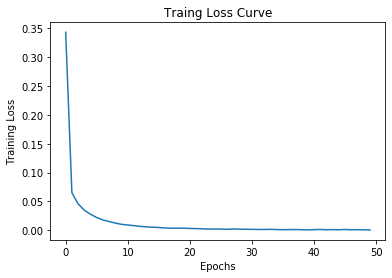

In [96]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Traing Loss Curve")
plt.show()

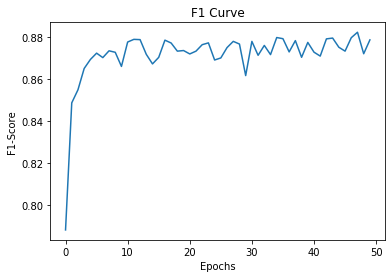

In [97]:

import matplotlib.pyplot as plt

plt.plot(f1score)
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.title("F1 Curve")
plt.show()


In [109]:
torch.save(model, '/root/biobert.bin')